In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-ultrasound-images-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1209633%2F2021025%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240510%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240510T191511Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D192be3d0213249b849aef5894eab2f922244dbcbb00c4d35ce18ab67895c149ee27407627c280a1bf0f5b9307308c3b0b7cb8007c361a121ae29346d193d64e2bc491a5cda589c45bf83260d5e71c1d0b7dcee16b8060987a087eeb7ac7514d386e270093a40bc069ecd9c80702799971064b98bf4c9910d659b94adbed859ff393d945a3ab929ddfc959fd23518004597bd92dfeacbddb06f6686ed5805f4ea18559a48d9494c6c8bf48024bceb82e6060220fc0728347d8f04b644cbe0d1ec73d23734166dc0306d69d87c025702e60f7aa0489c6fc8accfcd9fe82af05411a3d28050e14b152a624bca650d726dd2787a23e0cd1f27a6649a7e5372941b19'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 204421470 bytes downloaded
Downloaded and uncompressed: breast-ultrasound-images-dataset
Data source import complete.


# Loading and Processing Data

### Set up dataframe with category and image urls

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from skimage import data, io, filters

### Set up dataframe with category and image urls

import os
data = []
#!cp -r "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign" "./images"
#!cp -r "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant" "./images"
!cp -r "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT" "./"
os.makedirs("./images")
os.makedirs("./masks")

SHAPE = (250,250)
for dirname, _, filenames in os.walk("./Dataset_BUSI_with_GT"):
    if "normal" not in dirname:
        for filename in filenames:
            if "mask" not in filename:
                d1 = dirname.split('/')[2]
                d2 = os.path.join('./images', filename)
                d3 = os.path.join('./masks',filename)
                os.replace(dirname+"/"+filename.replace('.png','') + ("_mask.png"), "./masks/" + filename)
                os.replace(dirname+"/"+filename, "./images/" + filename)
                #print(dirname+"/"+filename,filename)

                data.append([d1,d2,d3])
df = pd.DataFrame(data, columns=['category','image','mask'])
df

,category,image,mask
0,benign,./images/benign (328).png,./masks/benign (328).png
1,benign,./images/benign (165).png,./masks/benign (165).png
2,benign,./images/benign (154).png,./masks/benign (154).png
3,benign,./images/benign (112).png,./masks/benign (112).png
4,benign,./images/benign (411).png,./masks/benign (411).png
...,...,...,...
642,malignant,./images/malignant (16).png,./masks/malignant (16).png
643,malignant,./images/malignant (180).png,./masks/malignant (180).png
644,malignant,./images/malignant (154).png,./masks/malignant (154).png
645,malignant,./images/malignant (15).png,./masks/malignant (15).png


In [ ]:
IMAGE_SIZE = (300,300)

for i in df.itertuples():
    img = io.imread(i.image)
    mask = io.imread(i.mask)


Index(['category', 'image', 'mask'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


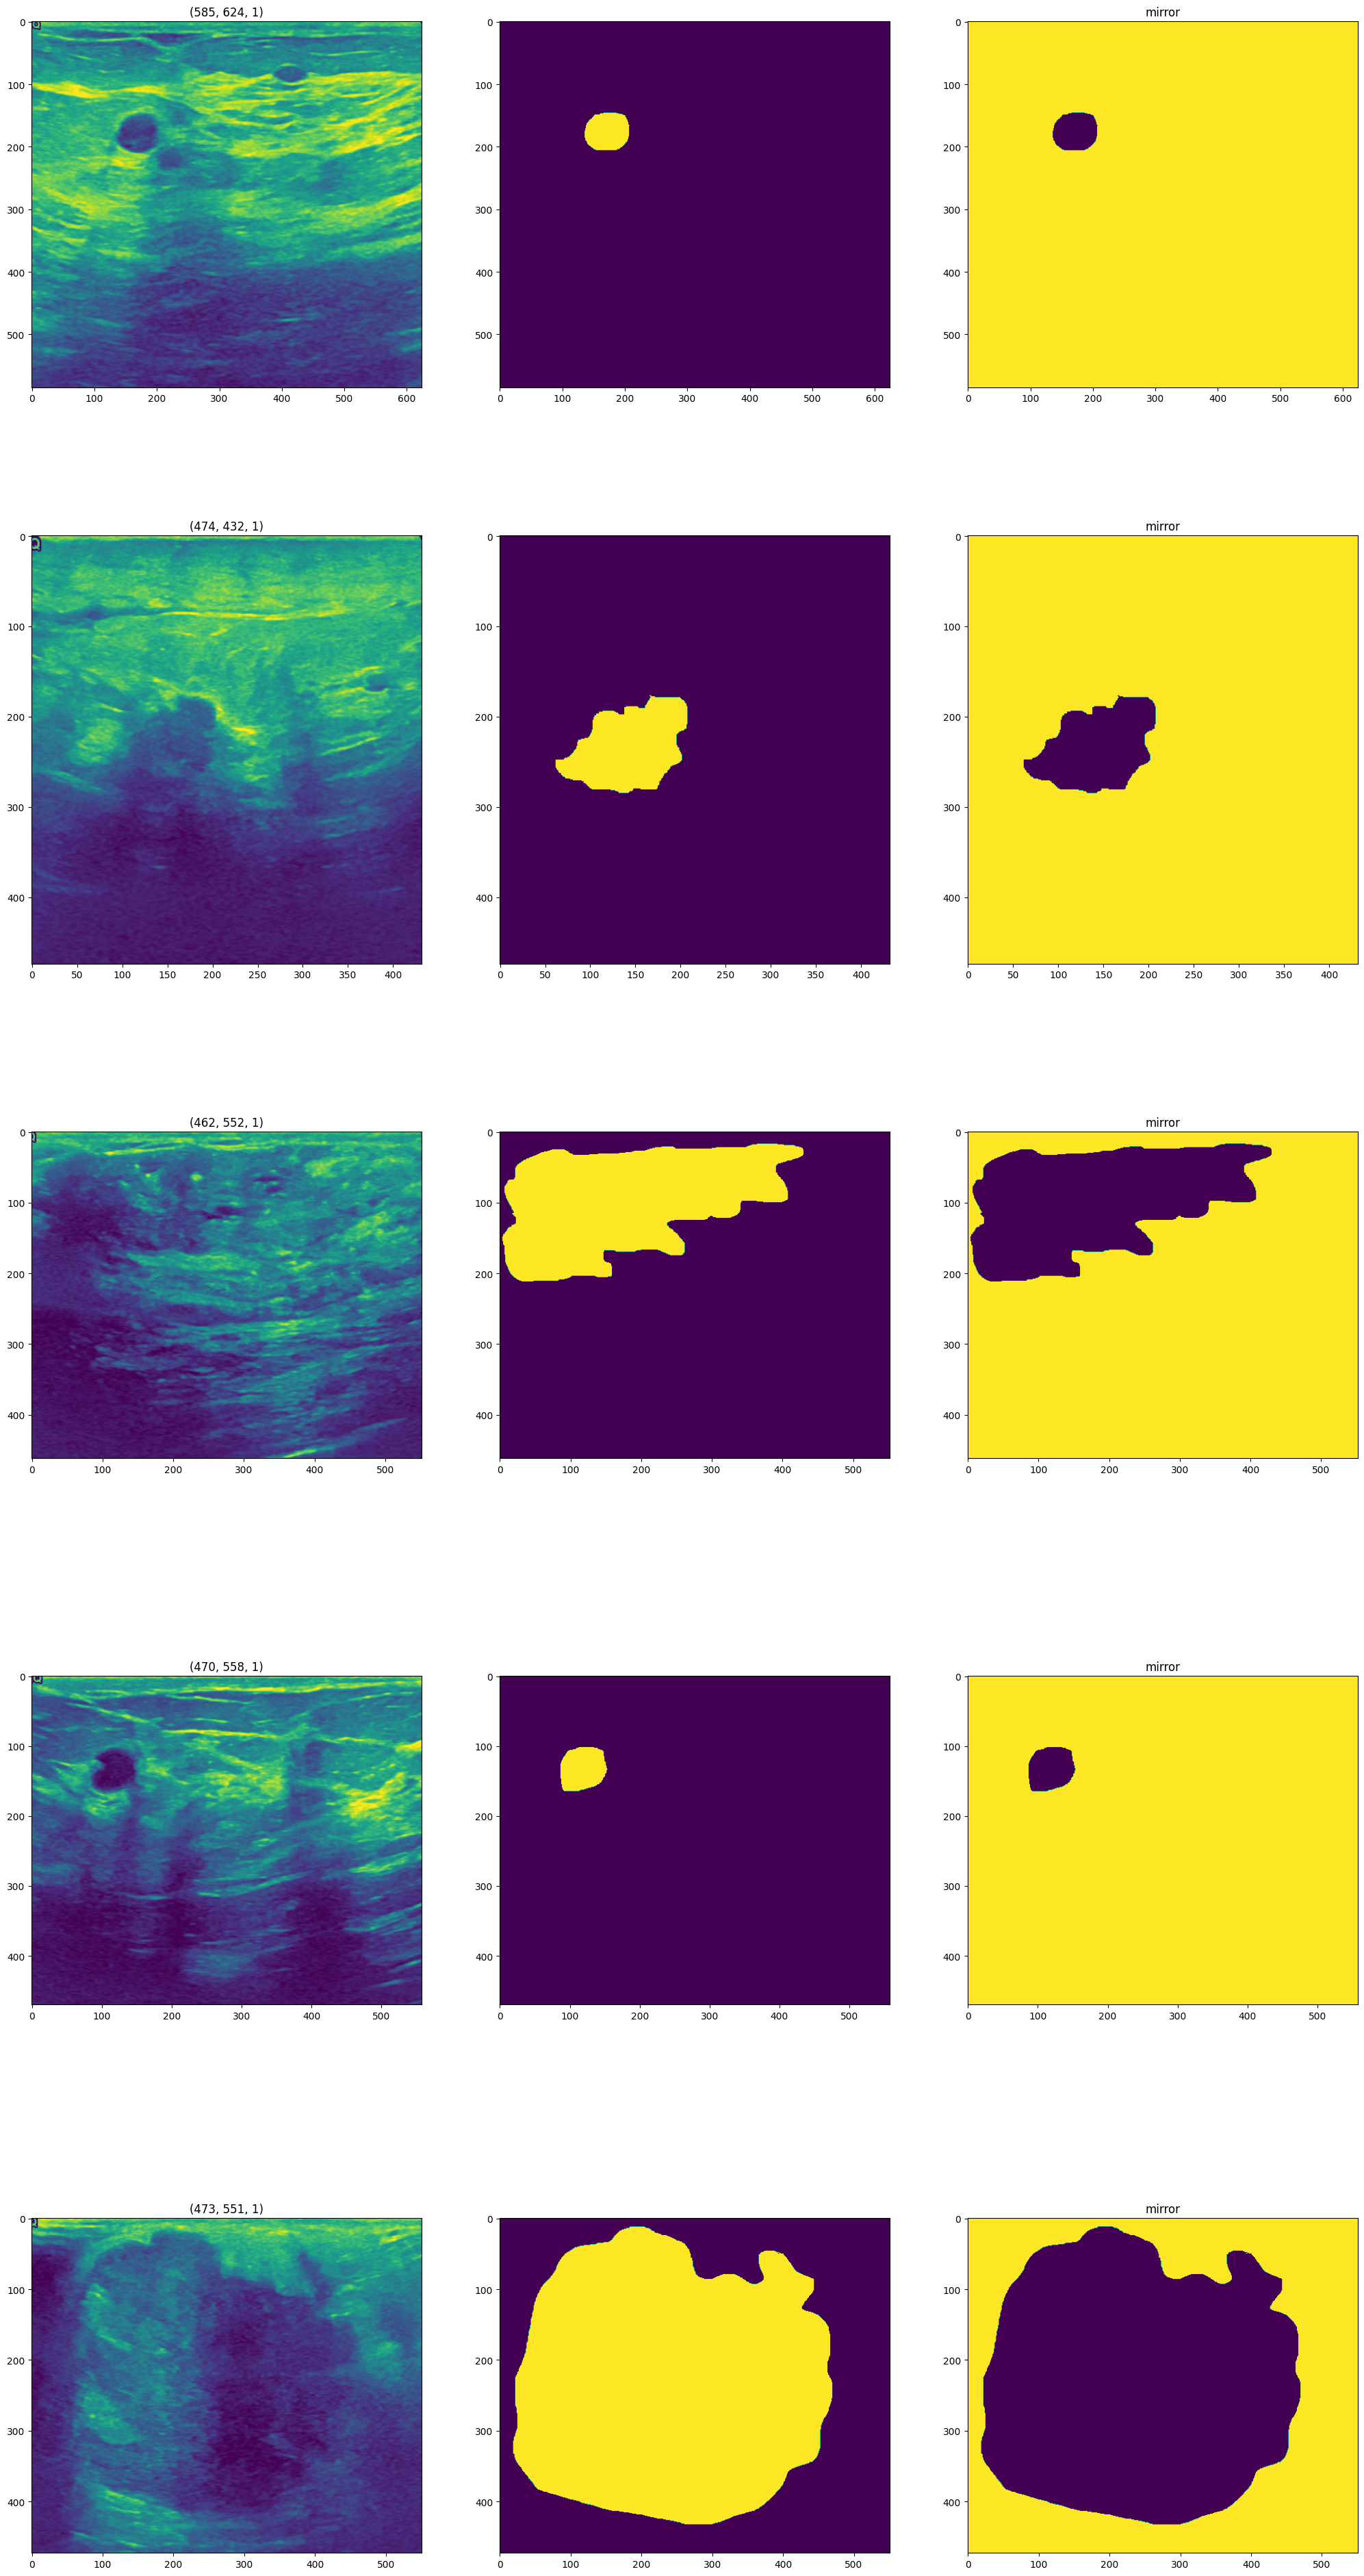

In [ ]:
IMAGE_SIZE = (250,250)

n=5
samples = df.sample(n=n, random_state=1)
print(samples.columns)
print(type(samples))
fig, axs = plt.subplots(n,3,figsize=(n*5,n*10))

for idx,i in enumerate(samples.itertuples()):
    mask = tf.io.read_file(i.mask)
    img = tf.io.read_file(i.image)

    img = tf.image.decode_jpeg(img, channels=1)
    mask = tf.image.decode_jpeg(mask, channels=1)

    mask = tf.image.convert_image_dtype(mask, tf.float32)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mirror = (mask+1)%2
    reshaped = tf.image.resize(img, size=[SHAPE[0],SHAPE[1]])
    axs[idx,0].set_title(str(img.shape))
    axs[idx,0].imshow(img)
    axs[idx,1].imshow(mask)
    axs[idx,2].set_title(str("mirror"))
    axs[idx,2].imshow(mirror)

In [ ]:
# https://stackoverflow.com/questions/63458668/tensorflow-image-dataset-from-directory-for-input-dataset-and-output-dataset
#edit this stuff
def process_img(file_path,shape=SHAPE,ismask=False):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=[shape[0],shape[1]])
    if ismask:
        mirror = (img+1)%2
        return tf.concat([img,mirror],2)
    return img

# Models

We're gonna explore a few different state-of-the-art image segmentation models with focus on biomedical ultrasound images and compare them.

## U-net

Link to the paper: https://arxiv.org/abs/1505.04597

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization, Input, Concatenate, MaxPooling2D, ReLU, Conv2D, Conv2DTranspose, Cropping2D, UpSampling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam, SGD, schedules
import tensorflow as tf

class U_Net():
    def __init__(self, inp=(572, 572, 1), min_filter=64, max_filter=1024, optimizer='Adam', loss=BinaryCrossentropy(), metrics=['accuracy', AUC()], model_change=False, data_change=False):
        self.max_filter = max_filter
        self.min_filter = min_filter
        self.model_change = model_change
        # Data Options
        if data_change: self.img_inp = self.preprocessed_input(Input(shape=inp))
        else: self.img_inp = Input(shape=inp)
        down, cac, down_list = self.downsample()
        lower, down_list = self.contracting_path(down, down_list)
        upper, cac2 = self.upsample(lower, down_list)
        out = Conv2D(2, (1), activation="softmax", name='output')(upper)
        self.out = out
        self.model = models.Model(inputs=self.img_inp, outputs=self.out)
        self.data_aug = data_change

        # Optimizer options
        if optimizer == 'Adam':
            learning_rate = 0.01
            self.optimizer = Adam(learning_rate=learning_rate)
        elif optimizer == 'SGD':
            learning_rate = 0.01
            self.optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
        elif optimizer == 'Adam_decay':
            initial_learning_rate = 0.01
            decay_steps = 1000
            decay_rate = 0.96
            self.optimizer = Adam(learning_rate=schedules.ExponentialDecay(
                initial_learning_rate, decay_steps, decay_rate))
        elif optimizer == 'SGD_decay':
          initial_learning_rate = 0.01
          decay_steps = 1000
          decay_rate = 0.96
          self.optimizer = SGD(learning_rate=schedules.ExponentialDecay(
              initial_learning_rate, decay_steps, decay_rate))

        # Loss options
        if loss == 'KLD': loss = KLDivergence()
        elif loss == 'DICE': loss = DiceLoss()

        self.model.compile(optimizer=self.optimizer, loss=loss, metrics=metrics)

    def preprocess_input(self, img):
        resized_img = tf.image.resize(img, (572, 572))
        normalized_img = resized_img / 255.0
        standardized_img = (normalized_img - tf.reduce_mean(normalized_img)) / tf.math.reduce_std(normalized_img)
        augmented_img = tf.image.random_flip_left_right(normalized_img)
        augmented_img = tf.image.random_flip_up_down(augmented_img)
        augmented_img = tf.image.random_contrast(augmented_img, lower=0.8, upper=1.2)
        augmented_img = tf.image.random_brightness(augmented_img, max_delta=0.1)
        return augmented_img

    def downsample(self):
        k = self.min_filter

        down_list = []
        res = self.img_inp
        while k < self.max_filter:
            res = Conv2D(k, (3, 3))(res)
            res = ReLU()(res)
            res = Conv2D(k, (3, 3))(res)
            res = ReLU()(res)
            down_list.append(res)
            cac = res
            res = MaxPooling2D(pool_size=(2, 2), strides=2)(res)
            curr = res
            k *= 2
        return res, cac, down_list

    def upsample(self, res, down_list):
        k = self.max_filter
        i = 0
        while k > self.min_filter:
            res = Conv2D(k//2, (3, 3))(res)
            res = ReLU()(res)
            k //= 2

            if k > self.min_filter:
                res = Conv2D(k//2, (3, 3))(res)
                res = ReLU()(res)
                res = Conv2DTranspose(k//2, (2, 2), strides=(
                    2, 2), padding='same')(res)
                left = down_list.pop()
                res = self.crop_and_conc(left, res)
                i += 1
            else:
                res = Conv2D(k, (3, 3))(res)
                res = ReLU()(res)
            cac = res
            curr = res
        return res, cac

    def contracting_path(self, down, down_list):
        res = Conv2D(self.max_filter, (3, 3))(down)
        res = ReLU()(res)
        res = Conv2D(self.max_filter//2, (3, 3))(res)
        res = ReLU()(res)
        # Model options
        if self.model_change:
          res = Conv2DTranspose(self.max_filter//2, (2, 2), strides=(2, 2), padding='same')(res)
        else:
          res = UpSampling2D((2,2))(res)
        left = down_list.pop()
        res = self.crop_and_conc(left, res)
        return res, down_list

    def crop_and_conc(self, left, right):
        left = Cropping2D(cropping=int(
            (left.shape[1]-right.shape[1])/2))(left)
        right = Concatenate()([left, right])
        return right

### Baseline

In [ ]:
shape = (300,300,1)
model = U_Net(inp=shape)

from glob import glob

x_files = glob('./images/*.png')
y_files = glob('./masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = model.model.get_layer('output').output_shape
print(mask_shape[1:])
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

print(type(files_ds))


batch_size = 32
LR = 1e-2
epochs = 75
history = model.model.fit(files_ds,epochs=epochs, batch_size=batch_size)

plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')
plt.ylim(0, 0.4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

(116, 116, 2)
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Epoch 1/75
647/647 [==============================] - 56s 56ms/step - loss: 1601.7706 - accuracy: 0.8956 - auc: 0.8847
Epoch 2/75
647/647 [==============================] - 37s 57ms/step - loss: 0.3068 - accuracy: 0.9083 - auc: 0.9064
Epoch 3/75
647/647 [==============================] - 37s 57ms/step - loss: 0.3069 - accuracy: 0.9083 - auc: 0.9057
Epoch 4/75
426/647 [==================>...........] - ETA: 12s - loss: 0.3131 - accuracy: 0.9056 - auc: 0.9017

In [ ]:
n=10

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = model.model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(20,40))
    axs[0].set_title("Ultrasound Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])
    plt.show()

    if i == n-1:
        break

### Model

In [ ]:
shape = (300,300,1)
model = U_Net(inp=shape, model_change=True)

from glob import glob

x_files = glob('./images/*.png')
y_files = glob('./masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = model.model.get_layer('output').output_shape
print(mask_shape[1:])
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

print(type(files_ds))


batch_size = 32
LR = 1e-2
epochs = 75
history = model.model.fit(files_ds,epochs=epochs, batch_size=batch_size)

plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')
plt.ylim(0, 0.4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

In [ ]:
n=10

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = model.model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(20,40))
    axs[0].set_title("Ultrasound Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])
    plt.show()

    if i == n-1:
        break

### Optimizer

#### 1) Adam

In [ ]:
shape = (300,300,1)
model = U_Net(inp=shape, optimizer='Adam')

from glob import glob

x_files = glob('./images/*.png')
y_files = glob('./masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = model.model.get_layer('output').output_shape
print(mask_shape[1:])
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

print(type(files_ds))


batch_size = 32
LR = 1e-2
epochs = 75
history = model.model.fit(files_ds,epochs=epochs, batch_size=batch_size)

plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')
plt.ylim(0, 0.4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

In [ ]:
n=10

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = model.model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(20,40))
    axs[0].set_title("Ultrasound Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])
    plt.show()

    if i == n-1:
        break

#### 2) SGD

In [ ]:
shape = (300,300,1)
model = U_Net(inp=shape, optimizer='SGD')

from glob import glob

x_files = glob('./images/*.png')
y_files = glob('./masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = model.model.get_layer('output').output_shape
print(mask_shape[1:])
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

print(type(files_ds))


batch_size = 32
LR = 1e-2
epochs = 75
history = model.model.fit(files_ds,epochs=epochs, batch_size=batch_size)

plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')
plt.ylim(0, 0.4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

In [ ]:
n=10

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = model.model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(20,40))
    axs[0].set_title("Ultrasound Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])
    plt.show()

    if i == n-1:
        break

#### 3) Adam Decay

In [ ]:
shape = (300,300,1)
model = U_Net(inp=shape, optimizer='Adam_decay')

from glob import glob

x_files = glob('./images/*.png')
y_files = glob('./masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = model.model.get_layer('output').output_shape
print(mask_shape[1:])
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

print(type(files_ds))


batch_size = 32
LR = 1e-2
epochs = 75
history = model.model.fit(files_ds,epochs=epochs, batch_size=batch_size)

plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')
plt.ylim(0, 0.4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

In [ ]:
n=10

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = model.model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(20,40))
    axs[0].set_title("Ultrasound Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])
    plt.show()

    if i == n-1:
        break

#### 4) SGD Decay

In [ ]:
shape = (300,300,1)
model = U_Net(inp=shape, optimizer='SGD_decay')

from glob import glob

x_files = glob('./images/*.png')
y_files = glob('./masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = model.model.get_layer('output').output_shape
print(mask_shape[1:])
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

print(type(files_ds))


batch_size = 32
LR = 1e-2
epochs = 75
history = model.model.fit(files_ds,epochs=epochs, batch_size=batch_size)

plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')
plt.ylim(0, 0.4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

In [ ]:
n=10

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = model.model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(20,40))
    axs[0].set_title("Ultrasound Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])
    plt.show()

    if i == n-1:
        break

### Loss

#### 1) KLD

In [ ]:
shape = (300,300,1)
model = U_Net(inp=shape, loss='KLD')

from glob import glob

x_files = glob('./images/*.png')
y_files = glob('./masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = model.model.get_layer('output').output_shape
print(mask_shape[1:])
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

print(type(files_ds))


batch_size = 32
LR = 1e-2
epochs = 75
history = model.model.fit(files_ds,epochs=epochs, batch_size=batch_size)

plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')
plt.ylim(0, 0.4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

In [ ]:
n=10

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = model.model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(20,40))
    axs[0].set_title("Ultrasound Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])
    plt.show()

    if i == n-1:
        break

#### 2) DICE

In [ ]:
shape = (300,300,1)
model = U_Net(inp=shape, loss='DICE')

from glob import glob

x_files = glob('./images/*.png')
y_files = glob('./masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = model.model.get_layer('output').output_shape
print(mask_shape[1:])
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

print(type(files_ds))


batch_size = 32
LR = 1e-2
epochs = 75
history = model.model.fit(files_ds,epochs=epochs, batch_size=batch_size)

plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')
plt.ylim(0, 0.4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

In [ ]:
n=10

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = model.model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(20,40))
    axs[0].set_title("Ultrasound Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])
    plt.show()

    if i == n-1:
        break

### Data

In [ ]:
shape = (300,300,1)
model = U_Net(inp=shape, data_change=True)

from glob import glob

x_files = glob('./images/*.png')
y_files = glob('./masks/*.png')
files_ds = tf.data.Dataset.from_tensor_slices((x_files, y_files))
mask_shape = model.model.get_layer('output').output_shape
print(mask_shape[1:])
files_ds = files_ds.map(lambda x, y: (process_img(x,shape), process_img(y,mask_shape[1:],ismask=True))).batch(1)

print(type(files_ds))


batch_size = 32
LR = 1e-2
epochs = 75
history = model.model.fit(files_ds,epochs=epochs, batch_size=batch_size)

plt.title("Reconstruction Loss")
epochs=len(history.history['loss'])
plt.plot(np.arange(0,epochs),history.history['loss'],label="Loss on Train Data", marker='*',color='green')
plt.ylim(0, 0.4)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,epochs,5),np.arange(0,epochs,5))
plt.legend()
plt.show()

In [ ]:
n=10

for i,file in enumerate(x_files):
    x_img = process_img(x_files[i],shape)
    y_img = process_img(y_files[i],mask_shape[1:],ismask=True)
    new_shape = tf.reshape(x_img,[1,x_img.shape[0],x_img.shape[1],x_img.shape[2]])
    new_mask = model.model.predict(new_shape)[0]
    fig, axs = plt.subplots(1,3,figsize=(20,40))
    axs[0].set_title("Ultrasound Image")
    axs[0].imshow(x_img[:,:,0])
    axs[1].set_title("Predicted Mask")
    axs[1].imshow(new_mask[:,:,0])
    axs[2].set_title("Real Mask")
    axs[2].imshow(y_img[:,:,0])
    plt.show()

    if i == n-1:
        break